In [1]:
import scipy.io as spio
import scipy.stats as st
from scipy.stats import norm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from math import exp
plt.style.use('bmh')
plt.rcParams['lines.linewidth'] = 1.5
plt.rcParams['axes.grid'] = False

## Loading and Preprocessing

In [2]:
location = spio.loadmat("location.mat")["location"]
spike_train = spio.loadmat("spike_train.mat")["spike_train"]

In [3]:
# transpose array into timestepsX1
location = np.transpose(location)

location is in the form 1 X timesteps and contains the location of the mouse across each step

In [4]:
spike_train = np.array(spike_train)

(74, 41349)

spike_train is in form timesteps x neurons
time-window is 0.05 seconds, the spatial bin is 0.02 meters.

In [6]:
# create a time array from all points
time = np.arange(0,41349)

((41349,), (41349,))

In [7]:

import math

# Calculate the velocity array
velocity = abs(np.gradient(location[:,0], time))

# thrshold of 5 cm/s
velocity_threshold = velocity>0.0025

# create new location and spike train arrays from filtered time points
new_location = location[velocity_threshold]
new_spike_train = spike_train[:,velocity_threshold]
new_spike_train = np.transpose(new_spike_train)

((5039, 1), (5039, 74))

''

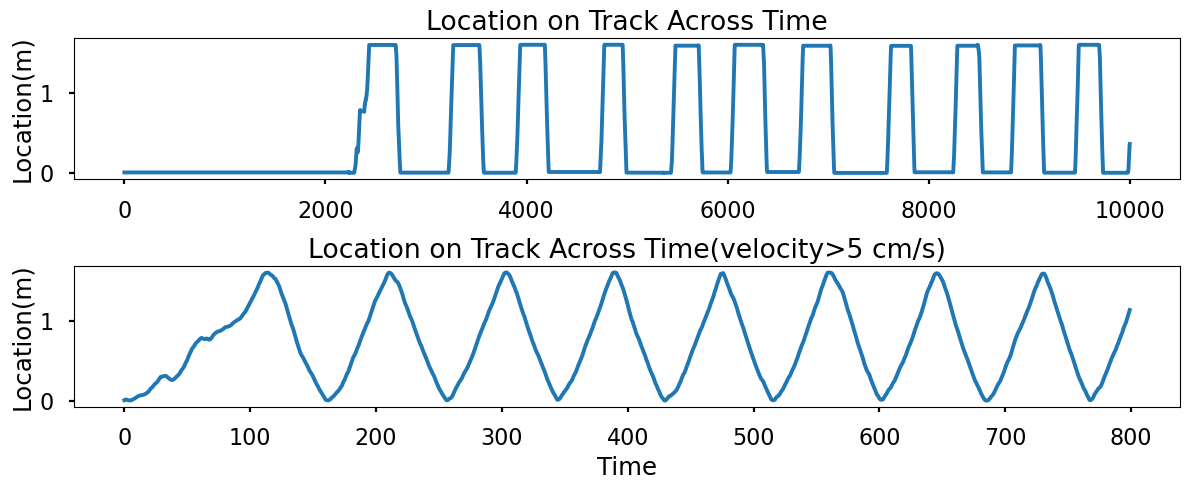

In [54]:
plt.figure(figsize = (12,5))
plt.subplot(2,1,1)
plt.plot(location[:10000])
plt.ylabel("Location(m)")
plt.title("Location on Track Across Time");
plt.subplot(2,1,2)
plt.plot(new_location[:800])
plt.xlabel("Time")
plt.ylabel("Location(m)")
plt.title("Location on Track Across Time(velocity>5 cm/s)")
plt.tight_layout()
;

## Encoding

In [21]:
# normalize array between values given 
def normalize(arr, t_min, t_max):
    norm = []
    diff = max(arr) - min(arr)
    for i in arr:
        temp = (((i - min(arr)) / diff) * (t_max - t_min)) + t_min
        norm.append(temp)
    return norm
 

In [22]:
# create an array of 0.02 m spatial bins for 1.6 m track
posbins = np.arange(0,1.64,0.02)

# Assign each location to a bin 
location_bins = np.digitize(np.transpose(new_location), posbins) -1
time_at_loc = np.zeros(81)
for i in range (81):
    if i == 0:
        not_zero = np.count_nonzero(location_bins)
        time_at_loc[i] = location_bins.size-not_zero
    else:
        time_at_loc[i]= np.count_nonzero(location_bins == i)
# initialize an array of firing counts by bins 
firing_bins = np.zeros((74,81))
for k in range(74):
    for i in range (len(new_spike_train[:,0])):
        loc_bin = location_bins[:,i]
        firing_bins[k][loc_bin] += new_spike_train[i,k]
#create an array of firing rates     
time_at_loc = time_at_loc*0.05
firing_rate = firing_bins/time_at_loc


In [23]:
def gauss(n=11, sigma=1):
    r = range(-int(n/2), int(n/2)+1)
    return norm.pdf(r, scale=sigma)
# n = 2.5 as 2.5 bins is equal to 5 cm
gaussian_kernel = gauss(n=2.5)

In [24]:
# create an array to store smoothed and normalized firing 
convolved_firing = np.zeros((74,81))
for i in range (74):
    convolved_firing[i] = np.convolve(firing_rate[i], gaussian_kernel, mode="same")
    convolved_firing[i] = normalize(convolved_firing[i],0,1)

In [25]:
# sort the neurons by location of max firing rate
max_vals = []
for i in range(convolved_firing.shape[0]):
    row = convolved_firing[i, :]
    max_val = np.max(row)
    max_index = np.argmax(row)
    max_vals.append((max_val, max_index, i))

#Sort in descending order by index
max_vals.sort(key=lambda x: x[1], reverse=False)

sorted_arr = np.array([convolved_firing[i, :] for _, _, i in max_vals])


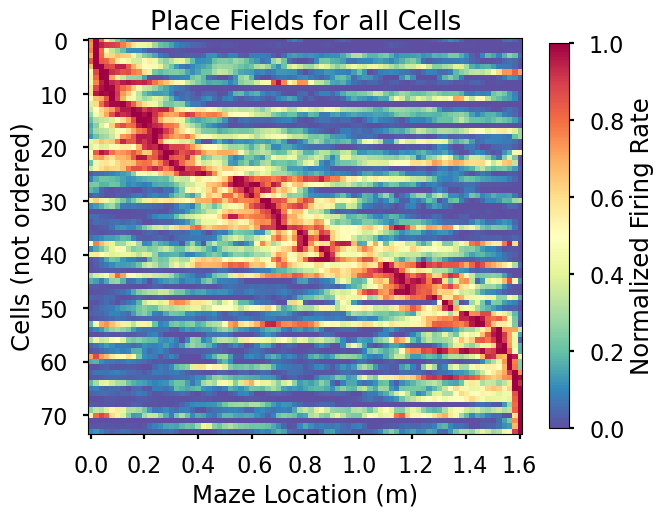

In [26]:
x_axis_lab = np.arange(0,1.62,0.2)
fig, ax = plt.subplots(figsize=[7,10])

# make im a pointer to the image
im = ax.imshow(sorted_arr,cmap = 'Spectral_r')
cb = fig.colorbar(im, shrink=0.5)
cb.ax.set_ylabel('Normalized Firing Rate')
ax.set_xlabel('Maze Location (m)')
# ax.set_xticks([0.0])
ax.set_xticks([0,10, 20, 30, 40, 50, 60, 70, 80])
ax.set_xticklabels(['0.0', '0.2', '0.4',' 0.6', '0.8', '1.0' ,' 1.2',' 1.4', '1.6'])
ax.set_ylabel('Cells (not ordered)')
ax.set_title("Place Fields for all Cells")
plt.show();

## Bayesian Decoding

want to find P(x|n): probability of rat being at location given spike counts
 Bayes rule: P(x∣n)P(n)=P(n∣x)P(x)
 P(n|x)=probability of n spikes in a given location x
 assume poisson distribution of spikes(for simplicity)
 assume spike count probabilities independent across neurons
     can multiply the probabilities together
     

In [15]:
# tuning curves without normalization
convolved_firing_n = np.zeros((74,81))
for i in range (74):
    convolved_firing_n[i] = np.convolve(firing_rate[i], gaussian_kernel, mode="same")

convolved_firing_n = np.transpose(convolved_firing_n)  

In [32]:
# times that rat was at each location
times_at_bin = np.zeros(81)
for i in range (81):
    if i == 0:
        not_zero = np.count_nonzero(location_bins)
        times_at_bin[i] = location_bins.size-not_zero
    else:
        times_at_bin[i]= np.count_nonzero(location_bins == i)

In [37]:
# creating model
time_length = new_spike_train[:,0]
new_spike_train
num_posbins = 81
Tau = 0.05
total_prob = np.zeros((len(time_length),num_posbins))

for i in range(num_posbins):
    Prior = times_at_bin[i]/np.sum(times_at_bin, axis=0)
    tempProd = np.nansum(np.log(np.tile(convolved_firing_n[i, :]+0.0001, (len(time_length), 1))**new_spike_train), axis=1)
    tempSum = np.exp(-Tau * np.nansum(convolved_firing_n[i, :]))
    total_prob[:, i] = np.exp(tempProd) * tempSum *Prior
total_prob /= np.tile(np.sum(total_prob, axis=1)[:, np.newaxis], (1, num_posbins))

In [38]:
dec_pos = np.zeros(len(time_length))
for time in range(len(total_prob)):
    likely_pos = np.argmax(total_prob[time,:])
    dec_pos[time] = likely_pos

In [39]:
dec_err = np.abs(dec_pos - location_bins[0])
cm_error = ((np.mean(dec_err))*0.02)*100
cm_error

15.649533637626515

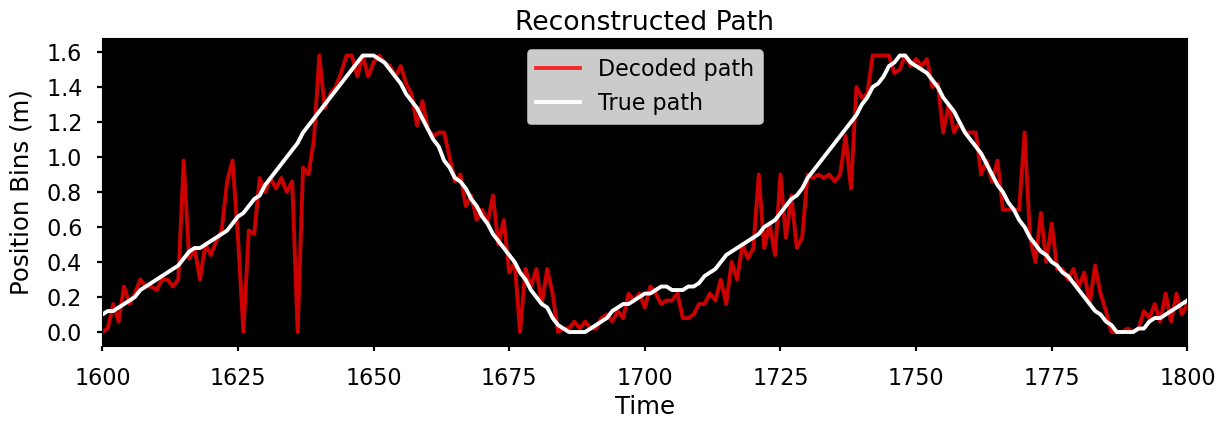

In [40]:
plt.style.use('default')

plt.style.use('seaborn-poster')
# plt.style.use("bmh")
plt.figure(figsize = (14,4))
ax = plt.axes()
plt.plot(dec_pos,alpha = 0.8, color = 'red', label = 'Decoded path')
plt.plot(location_bins[0], color = 'white', label = 'True path')
ax.set_facecolor('black')
plt.xlim((1600,1800))
plt.xlabel('Time')

plt.ylabel('Position Bins (m)')
plt.title("Reconstructed Path")

ax.set_yticks([0,10, 20, 30, 40, 50, 60, 70, 80])
ax.set_yticklabels(['0.0', '0.2', '0.4',' 0.6', '0.8', '1.0' ,' 1.2',' 1.4', '1.6'])
plt.legend();